In [10]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tqdm import tqdm

In [2]:
df = pd.read_parquet('preprocessed_final.parquet')

In [3]:
df_0 = df.loc[df['tsne_label'] == 0]
df_drift = df.loc[df['tsne_label'] != 0]

In [4]:
nb = GaussianNB(priors= None, var_smoothing= 0.001)
nb.fit(df_0.drop(columns=['label', 'tsne_label']), df_0['label'])

GaussianNB(var_smoothing=0.001)

In [5]:
results = {'nb' : None, 'rf' : None, 'svm' : None}

In [6]:
X, y = {}, {}
for group in df_drift['tsne_label'].unique():
    X[group] = df_drift.loc[ df['tsne_label']==group ].drop(columns=['label', 'tsne_label'])
    y[group] = df_drift.loc[ df['tsne_label']==group, 'label' ]

In [7]:
y_true, y_pred, groups = [], [], []

for group in [7, 1, 2, 5, 4, 3, 6]:
    for i in y[group].index:
        y_pred += nb.predict(X[group].loc[[i]]).tolist()
        y_true += y[group].loc[[i]].tolist()
        groups.append(group)
        nb.partial_fit(X[group].loc[[i]], y[group].loc[[i]])

In [8]:
results['nb'] = {'y_pred' : y_pred, 'y_true' : y_true}

In [20]:
rf = RandomForestClassifier(max_depth=30, min_samples_split=2, n_estimators=500, n_jobs=-1)
rf.fit(df_0.drop(columns=['label', 'tsne_label']).to_numpy(), df_0['label'].to_numpy())

RandomForestClassifier(max_depth=30, n_estimators=500, n_jobs=-1)

In [21]:
import numpy as np

y_true, y_pred, groups= [], [], []
X_rf = df_0.drop(columns=['label', 'tsne_label']).to_numpy()
y_rf = df_0['label'].to_numpy()

j=0
for group in tqdm([7, 1, 2, 5, 4, 3, 6]):
    for i in y[group].index:
        x_new = X[group].loc[[i]].to_numpy()
        y_new = y[group].loc[[i]].to_numpy()
        y_pred += rf.predict(x_new).tolist()
        y_true += y[group].loc[[i]].tolist()
        groups.append(group)
        X_rf = np.append(X_rf, x_new, axis=0)
        y_rf = np.append(y_rf, y_new, axis=0)
        if (j%1000) == 0 and j>0: rf.fit(X_rf, y_rf)
        

100%|██████████| 7/7 [06:16<00:00, 53.78s/it]


In [22]:
results['rf'] = {'y_pred' : y_pred, 'y_true' : y_true}

In [26]:
svm = SVC(C=100, kernel='rbf')
svm.fit(df_0.drop(columns=['label', 'tsne_label']).to_numpy(), df_0['label'].to_numpy())

SVC(C=100)

In [29]:
y_true, y_pred, groups= [], [], []
X_rf = df_0.drop(columns=['label', 'tsne_label']).to_numpy()
y_rf = df_0['label'].to_numpy()

j=0
for group in tqdm([7, 1, 2, 5, 4, 3, 6]):
    for i in y[group].index:
        x_new = X[group].loc[[i]].to_numpy()
        y_new = y[group].loc[[i]].to_numpy()
        y_pred += svm.predict(x_new).tolist()
        y_true += y[group].loc[[i]].tolist()
        groups.append(group)
        X_rf = np.append(X_rf, x_new, axis=0)
        y_rf = np.append(y_rf, y_new, axis=0)
        if (j%1000) == 0 and j>0: svm.fit(X_rf, y_rf)

100%|██████████| 7/7 [00:29<00:00,  4.19s/it]


In [30]:
results['svm'] = {'y_pred' : y_pred, 'y_true' : y_true}

In [31]:
import pickle

with open('concept-drift-labels.pickle', 'wb') as file:
    pickle.dump(results, file)

In [43]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

metrics_nb = pd.DataFrame(columns=['f1', 'accuracy', 'precision', 'recall'])
y_true = results['nb']['y_true']
y_pred = results['nb']['y_pred']

n = 1000
for i in range(n, len(y_true)):
    performance = {'f1' : f1_score(y_true[i-n:i], y_pred[i-n:i]),
                    'accuracy' : accuracy_score(y_true[i-n:i], y_pred[i-n:i]),
                    'precision' : precision_score(y_true[i-n:i], y_pred[i-n:i]),
                    'recall' : recall_score(y_true[i-n:i], y_pred[i-n:i])
                    }
    metrics_nb = pd.concat([metrics_nb, pd.DataFrame([performance])], ignore_index=True)

In [46]:
metrics_nb['groups'] = groups[n:]
metrics_nb

,f1,accuracy,precision,recall,groups
0,0.827098,0.829,0.836401,0.818000,1
1,0.827447,0.829,0.836735,0.818363,1
2,0.827098,0.829,0.836401,0.818000,1
3,0.825911,0.828,0.834356,0.817635,1
4,0.826748,0.829,0.836066,0.817635,1
...,...,...,...,...,...
8191,0.828794,0.824,0.817658,0.840237,6
8192,0.827988,0.823,0.816092,0.840237,6
8193,0.827988,0.823,0.816092,0.840237,6
8194,0.827653,0.823,0.815739,0.839921,6


In [47]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

metrics_rf = pd.DataFrame(columns=['f1', 'accuracy', 'precision', 'recall'])
y_true = results['rf']['y_true']
y_pred = results['rf']['y_pred']

n = 1000
for i in range(n, len(y_true)):
    performance = {'f1' : f1_score(y_true[i-n:i], y_pred[i-n:i]),
                    'accuracy' : accuracy_score(y_true[i-n:i], y_pred[i-n:i]),
                    'precision' : precision_score(y_true[i-n:i], y_pred[i-n:i]),
                    'recall' : recall_score(y_true[i-n:i], y_pred[i-n:i])
                    }
    metrics_rf = pd.concat([metrics_rf, pd.DataFrame([performance])], ignore_index=True)

metrics_rf['groups'] = groups[n:]
metrics_rf

,f1,accuracy,precision,recall,groups
0,0.965105,0.965,0.962227,0.968000,1
1,0.965174,0.965,0.962302,0.968064,1
2,0.965105,0.965,0.962227,0.968000,1
3,0.965035,0.965,0.962151,0.967936,1
4,0.965035,0.965,0.962151,0.967936,1
...,...,...,...,...,...
8191,0.952195,0.951,0.942085,0.962525,6
8192,0.951267,0.950,0.940270,0.962525,6
8193,0.951267,0.950,0.940270,0.962525,6
8194,0.951172,0.950,0.940154,0.962451,6


In [48]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

metrics_svm = pd.DataFrame(columns=['f1', 'accuracy', 'precision', 'recall'])
y_true = results['svm']['y_true']
y_pred = results['svm']['y_pred']

n = 1000
for i in range(n, len(y_true)):
    performance = {'f1' : f1_score(y_true[i-n:i], y_pred[i-n:i]),
                    'accuracy' : accuracy_score(y_true[i-n:i], y_pred[i-n:i]),
                    'precision' : precision_score(y_true[i-n:i], y_pred[i-n:i]),
                    'recall' : recall_score(y_true[i-n:i], y_pred[i-n:i])
                    }
    metrics_svm = pd.concat([metrics_svm, pd.DataFrame([performance])], ignore_index=True)

metrics_svm['groups'] = groups[n:]
metrics_svm

,f1,accuracy,precision,recall,groups
0,0.946322,0.946,0.940711,0.952000,1
1,0.946429,0.946,0.940828,0.952096,1
2,0.946322,0.946,0.940711,0.952000,1
3,0.946215,0.946,0.940594,0.951904,1
4,0.946215,0.946,0.940594,0.951904,1
...,...,...,...,...,...
8191,0.946026,0.945,0.941406,0.950690,6
8192,0.945098,0.944,0.939571,0.950690,6
8193,0.945098,0.944,0.939571,0.950690,6
8194,0.944990,0.944,0.939453,0.950593,6


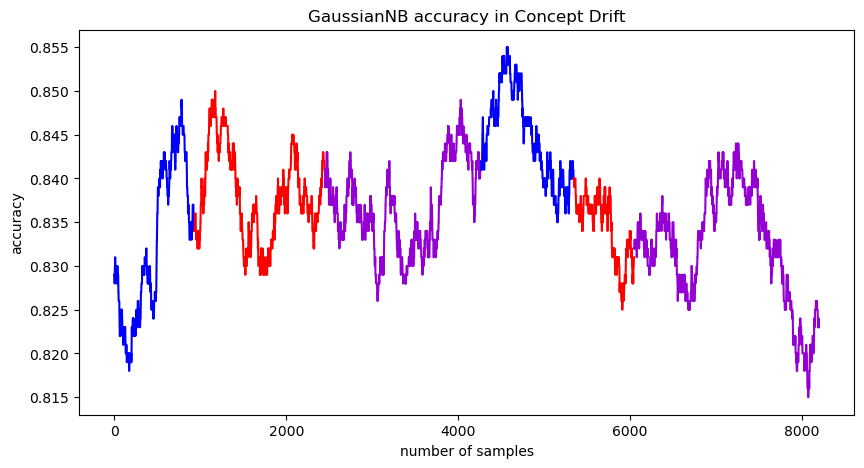

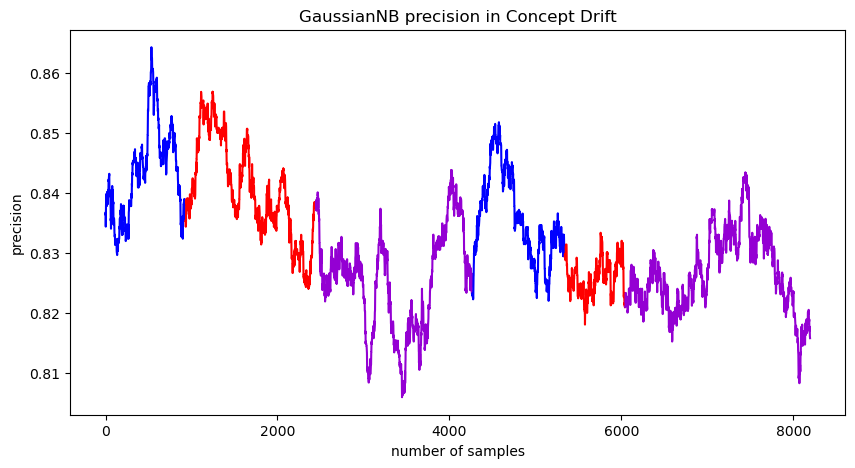

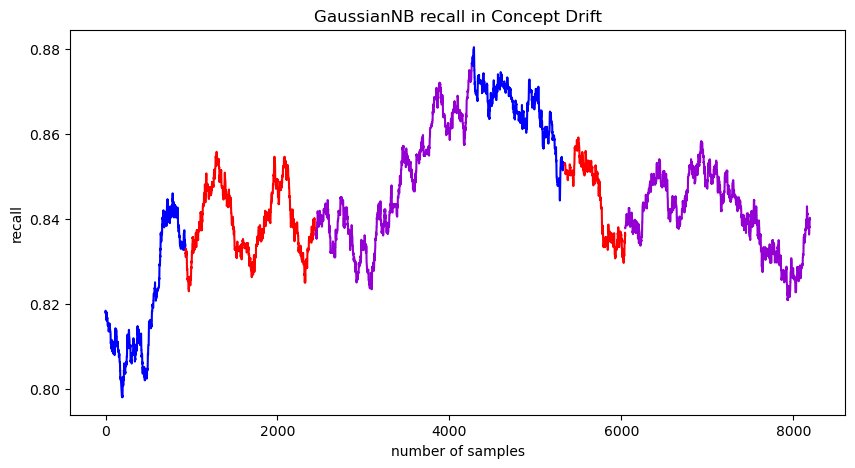

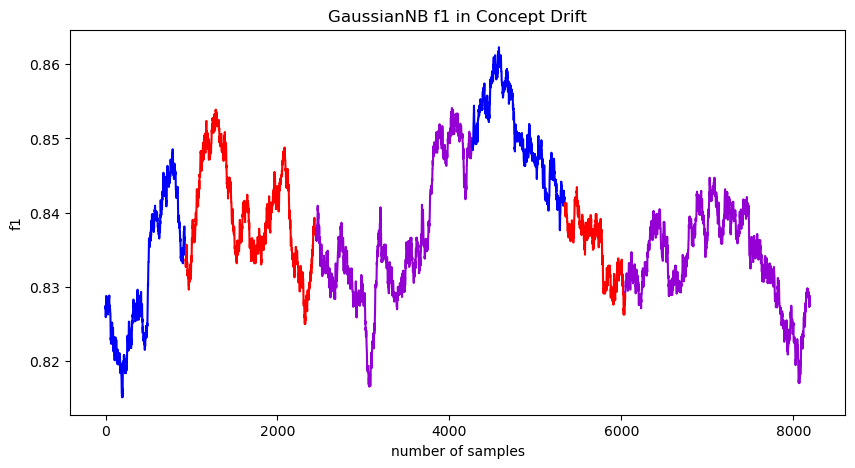

In [75]:
import matplotlib.pyplot as plt

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    colors = ['blue', 'red', 'darkviolet', 'blue', 'red', 'darkviolet']
    plt.figure(figsize=(10,5))
    # plt.scatter([i for i in range(metrics.shape[0])], metrics['accuracy'], s=0.5)
    for group, color in zip(metrics_nb['groups'].unique(), colors):
        plt.plot(metrics_nb.loc[metrics_nb['groups'] == group, metric], c=color)

    plt.title(f'GaussianNB {metric} in Concept Drift')
    plt.ylabel(metric)
    plt.xlabel('number of samples')
    plt.savefig(f'diagrams/nb-{metric}.png')
    plt.show()


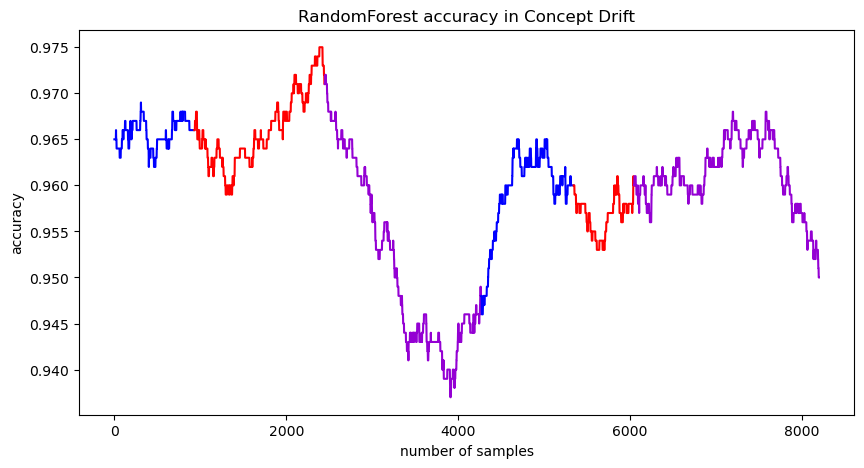

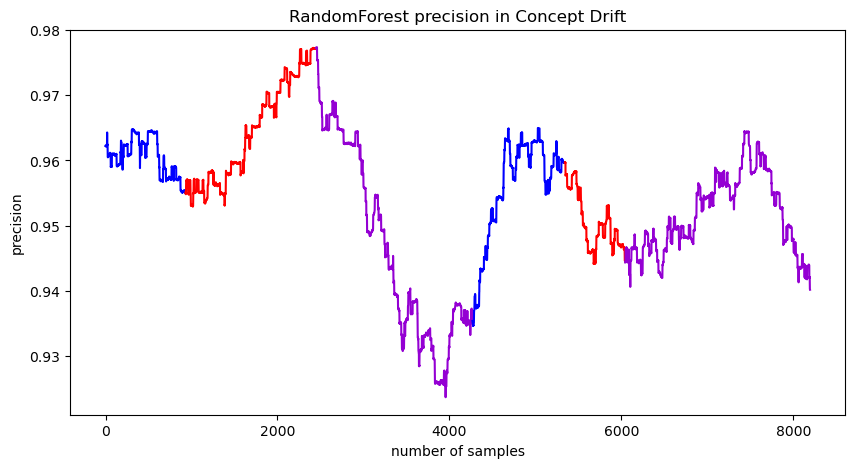

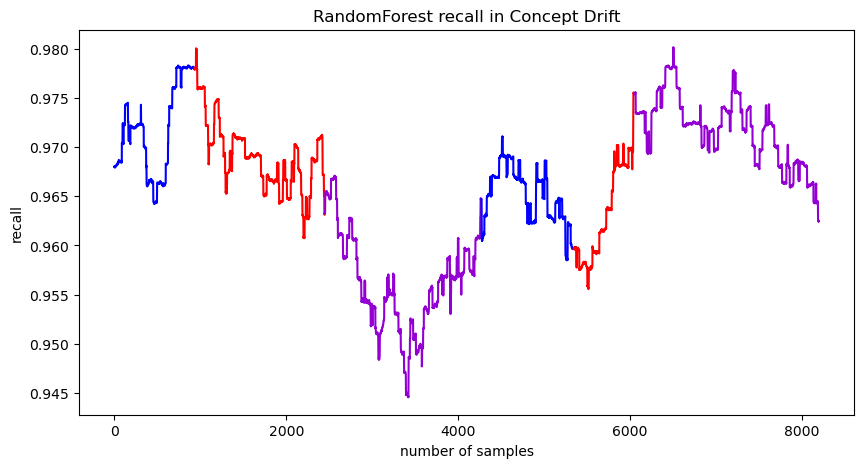

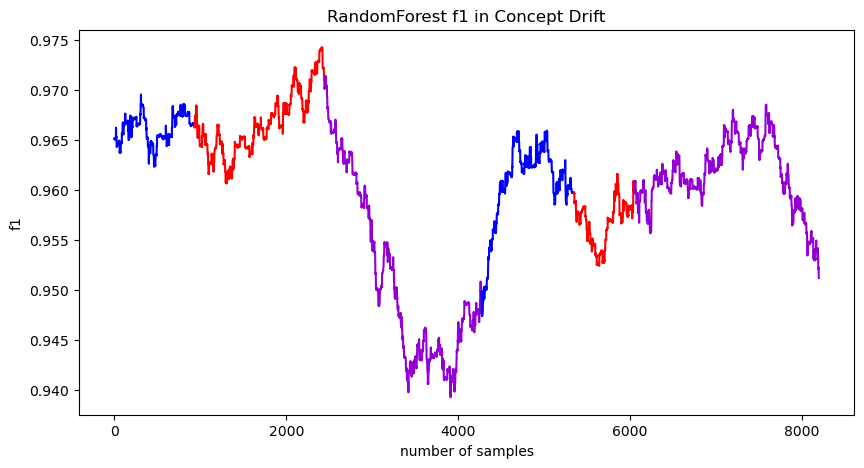

In [76]:
import matplotlib.pyplot as plt

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    colors = ['blue', 'red', 'darkviolet', 'blue', 'red', 'darkviolet']
    plt.figure(figsize=(10,5))
    # plt.scatter([i for i in range(metrics.shape[0])], metrics['accuracy'], s=0.5)
    for group, color in zip(metrics_rf['groups'].unique(), colors):
        plt.plot(metrics_rf.loc[metrics_rf['groups'] == group, metric], c=color)

    plt.title(f'RandomForest {metric} in Concept Drift')
    plt.ylabel(metric)
    plt.xlabel('number of samples')
    plt.savefig(f'diagrams/rf-{metric}.png')
    plt.show()

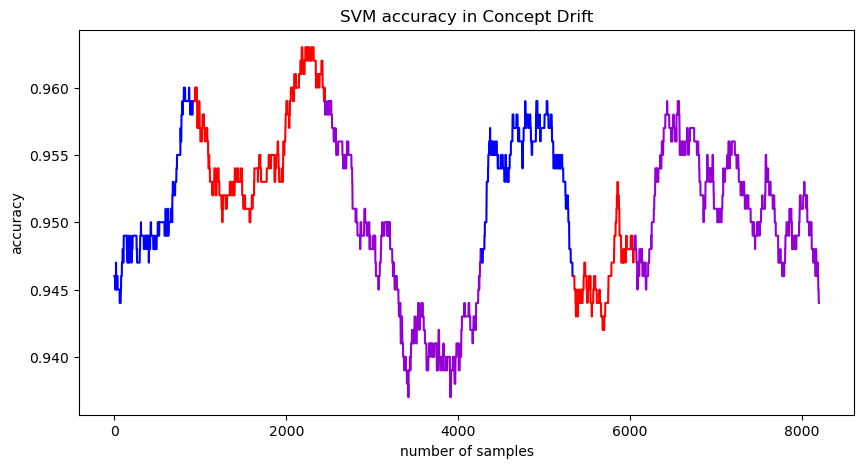

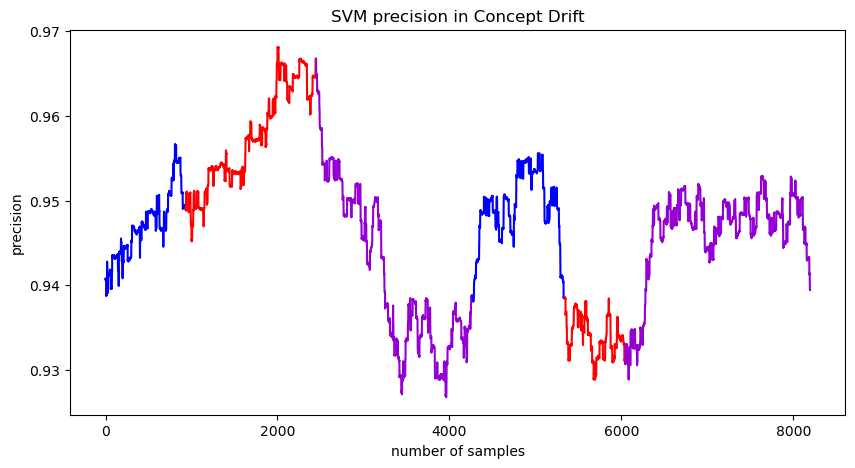

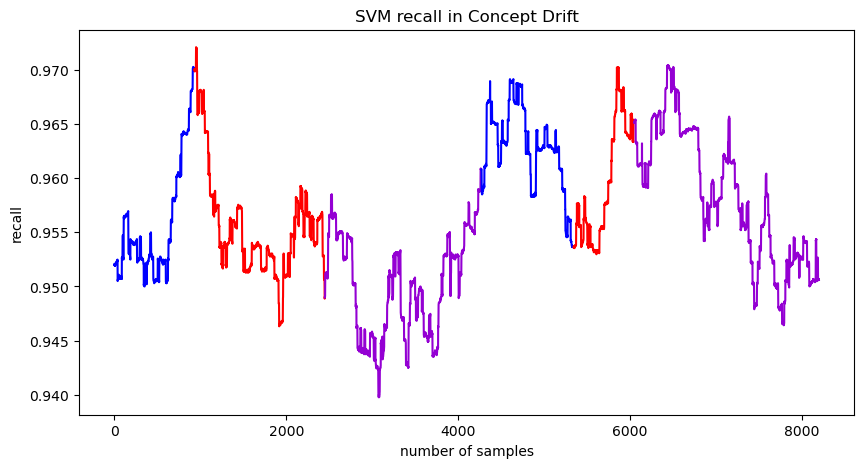

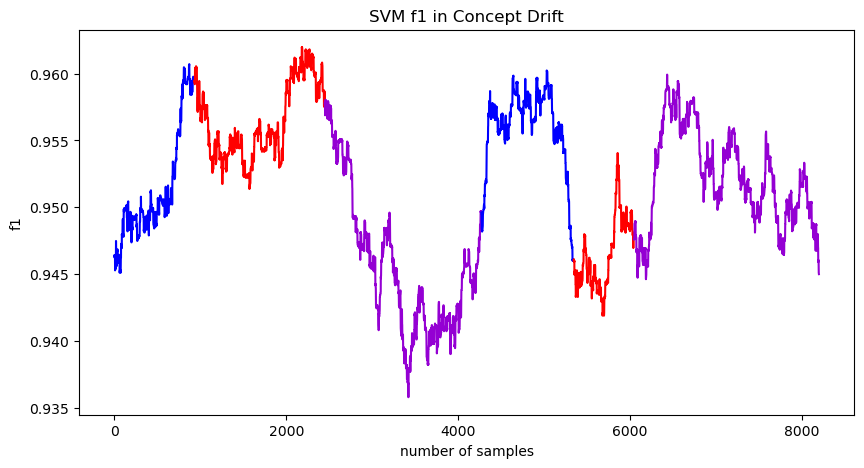

In [77]:
import matplotlib.pyplot as plt

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    colors = ['blue', 'red', 'darkviolet', 'blue', 'red', 'darkviolet']
    plt.figure(figsize=(10,5))
    # plt.scatter([i for i in range(metrics.shape[0])], metrics['accuracy'], s=0.5)
    for group, color in zip(metrics_svm['groups'].unique(), colors):
        plt.plot(metrics_svm.loc[metrics_svm['groups'] == group, metric], c=color)

    plt.title(f'SVM {metric} in Concept Drift')
    plt.ylabel(metric)
    plt.xlabel('number of samples')
    plt.savefig(f'diagrams/svm-{metric}.png')
    plt.show()